# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [75]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log


In [76]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [77]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [78]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [79]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [80]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df.loc[df[-1:].index, 'last_iter'] = 1
    except:
        print(filename)

    return df

# ray.init(num_cpus=16)

futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


(import_logs pid=48613) 
(import_logs pid=48623) 
(import_logs pid=48624) 
(import_logs pid=48628) 
(import_logs pid=48624) 
(import_logs pid=48616) 
(import_logs pid=48619) 
(import_logs pid=48622) 
(import_logs pid=48626) 
(import_logs pid=48615) 
(import_logs pid=48623) 
(import_logs pid=48617) 
(import_logs pid=48625) 
(import_logs pid=48619) 
(import_logs pid=48614) 
(import_logs pid=48623) 
(import_logs pid=48618) 
(import_logs pid=48618) 
(import_logs pid=48621) 


In [81]:

all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
all_data.rename({'move_strategy':'move_str', 'selection_strategy':'selec_str'}, axis=1, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(18338000, 19)
(18338, 19)


In [82]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18338000 entries, 0 to 18337999
Data columns (total 19 columns):
 #   Column      Dtype  
---  ------      -----  
 0   iter        int64  
 1   obj         float64
 2   aug_obj     float64
 3   return      float64
 4   X           object 
 5   Z           object 
 6   Q           float64
 7   max_iter    int64  
 8   neighbours  int64  
 9   alpha       float64
 10  exp_return  float64
 11  n_port      int64  
 12  k           int64  
 13  move_str    object 
 14  seed        float64
 15  selec_str   object 
 16  tag         object 
 17  filename    object 
 18  last_iter   float64
dtypes: float64(8), int64(5), object(6)
memory usage: 2.6+ GB


## Portfólios

### Geral

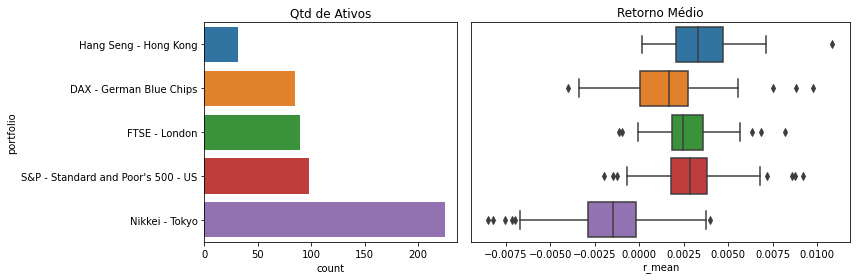

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [84]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

In [85]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

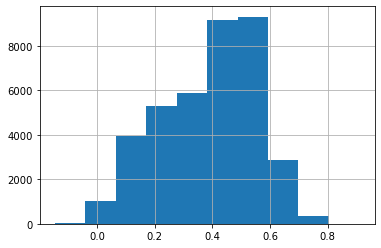

In [86]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

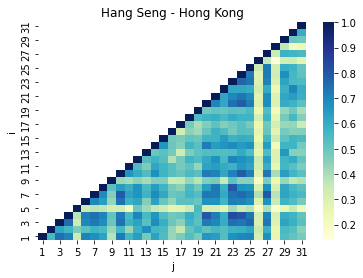

In [87]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [88]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


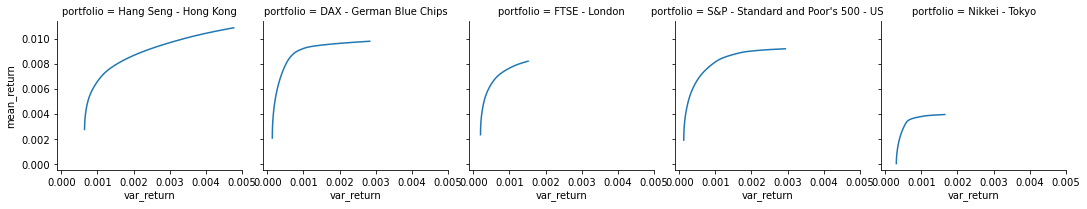

In [89]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

In [90]:
# sample = 5
# filenames = all_data.filename.unique()
# all_data = all_data[all_data.filename.isin(np.random.choice(filenames, sample))]
# print(all_data.shape)

In [91]:
all_data = all_data[all_data.n_port==1]

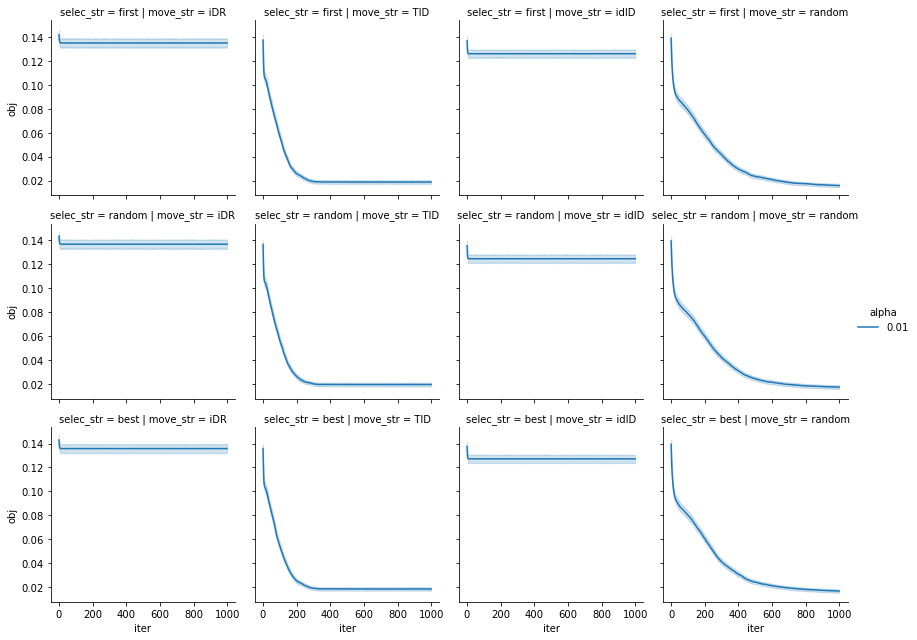

In [92]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

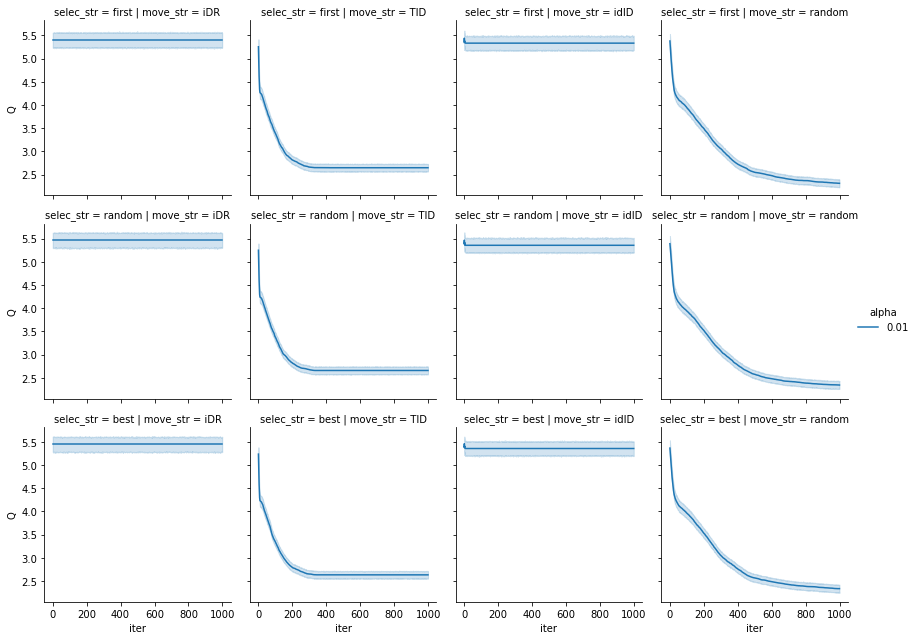

In [93]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'Q')
g.add_legend()
g=g

## Análise Best - Portfólio 1

In [94]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [95]:
print(best_data.shape)
best_data.drop(['X', 'Z',],axis=1,).head()

(18338, 19)


,iter,obj,aug_obj,return,Q,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,tag,filename,last_iter
999,999,0.112993,0.485872,0.003331,3.0,1000,100,0.01,0.0005,1,3,iDR,NaN,first,single_objective,log_gls_20211123_021226_880696.csv,1.0
1999,999,0.006933,0.029453,0.002566,2.0,1000,100,0.01,0.0015,1,5,TID,NaN,first,single_objective,log_gls_20211123_000921_688290.csv,1.0
2999,999,0.131939,0.393180,0.003856,5.0,1000,100,0.01,0.0030,1,5,iDR,NaN,random,single_objective,log_gls_20211123_061026_216869.csv,1.0
3999,999,0.236039,0.625503,0.005110,6.0,1000,100,0.01,0.0050,1,5,iDR,NaN,best,single_objective,log_gls_20211122_200215_145378.csv,1.0
4999,999,0.143475,0.427555,0.002798,5.0,1000,100,0.01,0.0015,1,5,idID,NaN,first,single_objective,log_gls_20211123_044431_197784.csv,1.0


In [96]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,18338.0,999.000000,0.000000,999.000000,999.000000,999.000000,999.000000,999.000000
obj,18338.0,0.074377,0.078679,0.000141,0.003286,0.026055,0.154794,0.272040
aug_obj,15373.0,0.226707,0.220438,0.001309,0.022621,0.132643,0.413176,1.049091
return,18338.0,0.003686,0.001369,0.000141,0.002959,0.003632,0.004350,0.010865
Q,18338.0,3.940397,2.937032,1.000000,1.000000,3.000000,6.000000,11.000000
max_iter,18338.0,1000.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,18338.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,18338.0,0.010000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000
exp_return,18338.0,0.003039,0.002095,0.000500,0.001500,0.002500,0.004000,0.010000
n_port,18338.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


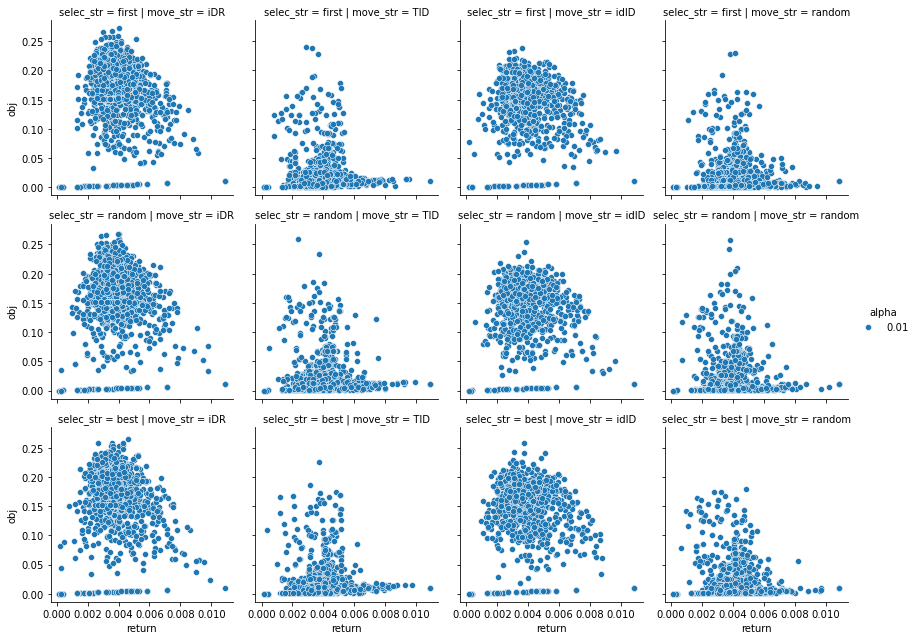

In [97]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

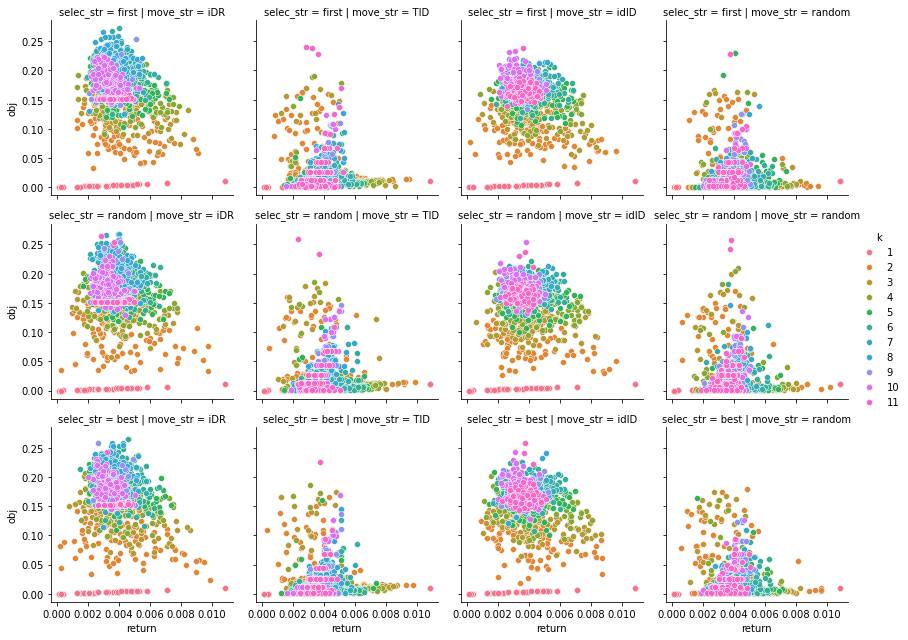

In [98]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [99]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,18338.0,999.000000,0.000000,999.000000,999.000000,999.000000,999.000000,999.000000
obj,18338.0,0.074377,0.078679,0.000141,0.003286,0.026055,0.154794,0.272040
aug_obj,15373.0,0.226707,0.220438,0.001309,0.022621,0.132643,0.413176,1.049091
return,18338.0,0.003686,0.001369,0.000141,0.002959,0.003632,0.004350,0.010865
Q,18338.0,3.940397,2.937032,1.000000,1.000000,3.000000,6.000000,11.000000
max_iter,18338.0,1000.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,18338.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,18338.0,0.010000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000
exp_return,18338.0,0.003039,0.002095,0.000500,0.001500,0.002500,0.004000,0.010000
n_port,18338.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [100]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [101]:
uef[uef.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_return,2000.0,0.006825,0.002334,0.002784,0.004804,0.006825,0.008845,0.010865
var_return,2000.0,0.001579,0.001116,0.000642,0.000716,0.001058,0.002150,0.004776
port,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'mean_return')

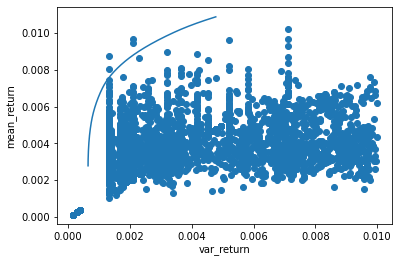

In [102]:
data = best_data[best_data['obj']<0.01]
data = data[data.n_port==1]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [103]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,18338.0,999.000000,0.000000,999.000000,999.000000,999.000000,999.000000,999.000000
obj,18338.0,0.074377,0.078679,0.000141,0.003286,0.026055,0.154794,0.272040
aug_obj,15373.0,0.226707,0.220438,0.001309,0.022621,0.132643,0.413176,1.049091
return,18338.0,0.003686,0.001369,0.000141,0.002959,0.003632,0.004350,0.010865
Q,18338.0,3.940397,2.937032,1.000000,1.000000,3.000000,6.000000,11.000000
max_iter,18338.0,1000.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,18338.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,18338.0,0.010000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000
exp_return,18338.0,0.003039,0.002095,0.000500,0.001500,0.002500,0.004000,0.010000
n_port,18338.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)

(1545, 20)


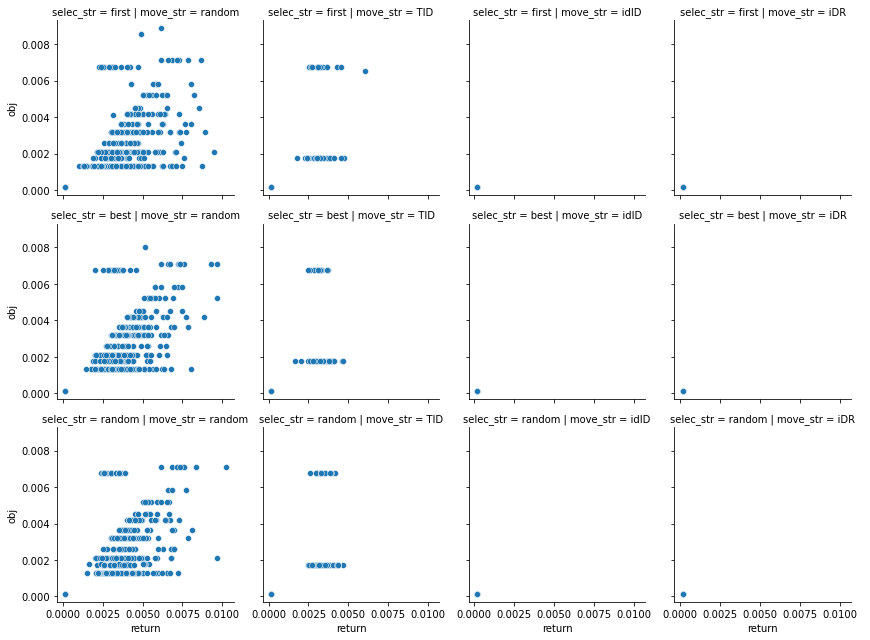

In [105]:
g = sns.FacetGrid(data=best_best_data[best_best_data.obj<0.01], col='move_str', row='selec_str')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [112]:
port = 1
data = best_best_data[best_best_data.n_port==port]
data = data[data['obj']<0.01]
plt.plot(uef[uef.port==port].var_return, uef[uef.port==port].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

AttributeError: 'DataFrame' object has no attribute 'n_port'

In [107]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0005  0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  \
move_str selec_str                                                           
TID      best          110     220     110     220     109     219      95   
         first         110     220     110     220     110     218     100   
         random        110     220     110     220     109     214      97   
iDR      best          110     220     110     220     110     215      95   
         first         110     220     110     220     110     215      98   
         random        110     220     110     220     110     219      94   
idID     best          110     220     110     220     109     217     101   
         first         110     220     110     220     109     213     104   
         random        110     220     110     220     110     215      95   
random   best          110     220     110     220     110     213     100   
         first         110     220     110     220     110     215      99   
         random        110     220     110     220     110     213     102   

exp_return          0.0040  0.0045  0.0050  0.0055  0.0060  0.0065  0.0070  \
move_str selec_str                                                           
TID      best          165      54      51      18      31      14      23   
         first         153      51      59      16      28      13      22   
         random        158      49      59      20      27      12      22   
iDR      best          156      49      61      19      34      13      22   
         first         155      47      61      20      31      14      25   
         random        159      52      65      19      27      14      20   
idID     best          159      49      58      17      34      13      25   
         first         159      54      60      21      36      14      26   
         random        159      40      55      16      29      16      23   
random   best          164      50      60      21      31      14      22   
         first         146      55      54      20      24      15      24   
         random        158      62      56      18      27      12      24   

exp_return          0.0075  0.0080  0.0085  0.0090  0.0095  0.0100  
move_str selec_str                                                  
TID      best           10      23      10      22      10      20  
         first          11      20      11      20      10      20  
         random         11      21      10      20      10      20  
iDR      best           11      21      10      21      11      20  
         first          10      20      10      20      10      20  
         random         10      20      10      22      10      20  
idID     best           10      23      10      20      10      20  
         first          11      21      10      20      10      20  
         random         10      20      10      21      10      20  
random   best           12      21      10      20      10      20  
         first          11      21      10      20      10      20  
         random         10      22      10      20      10      20

In [108]:
best_data.groupby(['Q', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='Q', values='obj')

Q                    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0   \
move_str selec_str                                                           
TID      best       302.0  719.0  174.0  131.0   94.0   55.0   31.0   20.0   
         first      305.0  695.0  184.0  128.0   97.0   50.0   36.0   17.0   
         random     305.0  689.0  181.0  130.0   94.0   56.0   42.0   11.0   
iDR      best       300.0  119.0  107.0  118.0  110.0  131.0  134.0   90.0   
         first      300.0  130.0  109.0  113.0  131.0   94.0  131.0  113.0   
         random     300.0  122.0  106.0  112.0  116.0  116.0  132.0  109.0   
idID     best       300.0  125.0  109.0  101.0  125.0  118.0  118.0   77.0   
         first      300.0  132.0   99.0  122.0  124.0  125.0  107.0   68.0   
         random     300.0  121.0  103.0  115.0  103.0  127.0  110.0   55.0   
random   best       680.0  348.0  198.0  109.0  104.0   47.0   35.0   13.0   
         first      671.0  349.0  187.0  122.0  100.0   38.0   28.0   15.0   
         random     675.0  354.0  193.0  104.0  108.0   49.0   31.0   17.0   

Q                    9.0    10.0  11.0  
move_str selec_str                      
TID      best         5.0    2.0   1.0  
         first        6.0    1.0   3.0  
         random       9.0    NaN   2.0  
iDR      best       201.0  217.0   1.0  
         first      193.0  212.0   NaN  
         random     204.0  211.0   3.0  
idID     best       459.0    NaN   3.0  
         first      470.0    NaN   1.0  
         random     471.0    1.0   3.0  
random   best         4.0    NaN   NaN  
         first        3.0    NaN   1.0  
         random       1.0    NaN   2.0

In [117]:
best_data_pivot = best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

best_data_pivot.head()

exp_return            0.0005    0.0010    0.0015    0.0020    0.0025  \
move_str selec_str                                                     
TID      best       0.001309  0.000141  0.000141  0.000141  0.000282   
         first      0.001309  0.001309  0.000392  0.000141  0.001309   
         random     0.000282  0.000282  0.000282  0.000141  0.001309   
iDR      best       0.000282  0.000141  0.000282  0.000282  0.000392   
         first      0.001309  0.000392  0.000282  0.000282  0.000282   

exp_return            0.0030    0.0035    0.0040    0.0045    0.0050  \
move_str selec_str                                                     
TID      best       0.000392  0.000392  0.000392  0.000282  0.000282   
         first      0.000141  0.001759  0.000282  0.000141  0.001487   
         random     0.000141  0.000282  0.000392  0.001487  0.000141   
iDR      best       0.000141  0.000282  0.000141  0.000282  0.000141   
         first      0.000141  0.000141  0.000282  0.001309  0.000141   

exp_return            0.0055    0.0060    0.0065    0.0070    0.0075  \
move_str selec_str                                                     
TID      best       0.000282  0.000392  0.000282  0.000141  0.000141   
         first      0.000282  0.000141  0.000392  0.000392  0.001309   
         random     0.000392  0.001759  0.000282  0.000282  0.000392   
iDR      best       0.000141  0.000141  0.000141  0.000141  0.000141   
         first      0.000392  0.000282  0.000141  0.000392  0.001759   

exp_return            0.0080    0.0085    0.0090    0.0095    0.0100  
move_str selec_str                                                    
TID      best       0.001309  0.000282  0.001759  0.000282  0.000141  
         first      0.001309  0.001879  0.000141  0.000282  0.000141  
         random     0.000282  0.000141  0.000282  0.000141  0.001309  
iDR      best       0.001309  0.000141  0.000392  0.000141  0.000141  
         first      0.000392  0.001879  0.000392  0.000282  0.000392

Text(0.5, 1.0, 'Object Function')

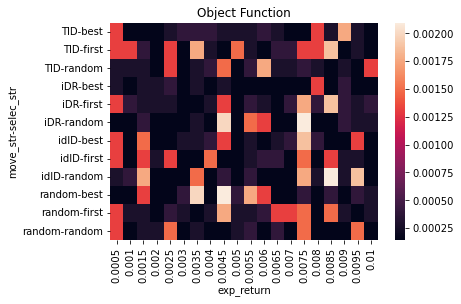

In [120]:
sns.heatmap(best_data_pivot)
plt.title('Object Function')

In [121]:
%matplotlib widget
# aka import ipympl

import matplotlib.pyplot as plt

plt.plot([0, 1, 2, 2])
plt.show()

ModuleNotFoundError: No module named 'ipympl'